In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch import FloatTensor as tensor
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [223]:
def preprocessing(data: pd.DataFrame):
    dataframe=data.copy()
    dataframe.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    category_data = ['Embarked']
    for name in category_data:
        dataframe[name] = dataframe[name].astype('category')
    dataframe = pd.get_dummies(dataframe, dtype=int)
    dataframe.drop(['Sex_female'], axis=1, inplace=True)
    dataframe['IsAgeNull']=data['Age'].apply(lambda x:1 if pd.isna(x) else 0)
    dataframe['Age']=data['Age'].apply(lambda x:0 if pd.isna(x) else x)
    return dataframe

In [224]:
data = pd.read_csv('./datasets/train.csv')

In [225]:
data=preprocessing(data)

<Axes: >

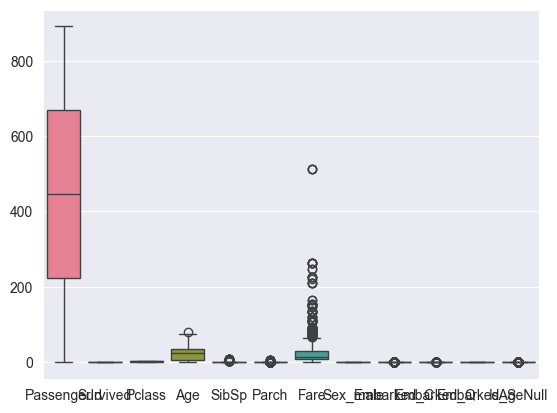

In [226]:
sns.boxplot(data=data)

In [227]:
def match_scale(dataframe:pd.DataFrame, columns:dict[str:int]):
    df=dataframe.copy()
    max_vals=data.max()
    for col in columns.keys():
        df[col]=df[col]/max_vals[col]*columns[col]
    return df

In [228]:
test = pd.read_csv('./datasets/test.csv')

In [229]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [230]:
test=preprocessing(test)

In [231]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S,IsAgeNull
0,892,3,34.5,0,0,7.8292,1,0,1,0,0
1,893,3,47.0,1,0,7.0000,0,0,0,1,0
2,894,2,62.0,0,0,9.6875,1,0,1,0,0
3,895,3,27.0,0,0,8.6625,1,0,0,1,0
4,896,3,22.0,1,1,12.2875,0,0,0,1,0


In [232]:
test=match_scale(test, {'Age':2, 'Fare':2, 'Parch':2, 'SibSp':2})

In [233]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S,IsAgeNull
0,892,3,0.8625,0.00,0.000000,0.030563,1,0,1,0,0
1,893,3,1.1750,0.25,0.000000,0.027326,0,0,0,1,0
2,894,2,1.5500,0.00,0.000000,0.037817,1,0,1,0,0
3,895,3,0.6750,0.00,0.000000,0.033816,1,0,0,1,0
4,896,3,0.5500,0.25,0.333333,0.047967,0,0,0,1,0


In [234]:
class learning(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(10, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 4),
            nn.LeakyReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )
        # self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.layer(x)
        return x

In [235]:
model = learning()
model.load_state_dict(torch.load('model.pt'))
model.eval()

learning(
  (layer): Sequential(
    (0): Linear(in_features=10, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=8, out_features=4, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [236]:
test_tensor=tensor(test.values)

In [237]:
pid=test['PassengerId']
survived=pd.Series([1 if model(test_tensor[i][1:])>0.5 else 0 for i in range(len(test_tensor))], name='Survived')

In [238]:
result=pd.concat([pid, survived], axis=1)

In [239]:
result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [240]:
result.to_csv('survived_result.csv', index=False)